# <strong>STOR 515 Final Project</strong>
Fraud Detection Using Randomized Weighted Majority Algorithm\
Group 2:\
Zenan Ji\
Xinyue Xing\
William Li\
Zhan Lin

## Library importing and data loading

In [191]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegressionCV, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, classification_report, confusion_matrix

In [162]:
df = pd.read_csv('../data/card_transdata.csv')
df.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


## Data Processing

In [163]:
# check for null in each column
df.isnull().sum()

distance_from_home                0
distance_from_last_transaction    0
ratio_to_median_purchase_price    0
repeat_retailer                   0
used_chip                         0
used_pin_number                   0
online_order                      0
fraud                             0
dtype: int64

In [164]:
# check data types of each column
df.dtypes

distance_from_home                float64
distance_from_last_transaction    float64
ratio_to_median_purchase_price    float64
repeat_retailer                   float64
used_chip                         float64
used_pin_number                   float64
online_order                      float64
fraud                             float64
dtype: object

In [165]:
# convert the binary columns into Int type
num_cols = ['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price']
cat_cols = ['repeat_retailer', 'used_chip', 'used_pin_number', 'online_order', 'fraud']
for col in cat_cols:
  df[col] = df[col].astype('int')

In [166]:
# check the statistics of each numerical column
df[num_cols].describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price
count,1000000.000000,1000000.000000,1000000.000000
mean,26.628792,5.036519,1.824182
std,65.390784,25.843093,2.799589
min,0.004874,0.000118,0.004399
25%,3.878008,0.296671,0.475673
50%,9.967760,0.998650,0.997717
75%,25.743985,3.355748,2.096370
max,10632.723672,11851.104565,267.802942


<AxesSubplot:xlabel='Fraud or Not', ylabel='Count'>

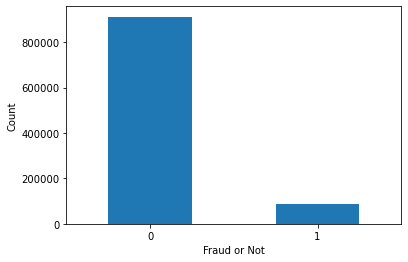

In [167]:
df['fraud'].value_counts().plot(kind='bar', ylabel='Count', rot=0, xlabel = 'Fraud or Not')

The bar chart shows that the dataset is extremely imbalanced, so we should be aware to apply techniques like upsampling or downsampling when training and testing our models

## Model (expert) Training

In [101]:
df_downsampled[num_cols] = (df-df.min())/(df.max()-df.min())

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price
13,2.131956,56.372401,6.358667
24,3.803057,67.241081,1.872950
29,15.694986,175.989182,0.855623
35,26.711462,1.552008,4.603601
36,10.664474,1.565769,4.886521
...,...,...,...
300634,2.852897,1.975632,1.879621
474397,1.223765,0.177362,3.432826
666255,4.205574,0.666426,1.045838
573664,12.560386,0.238567,0.198776


In [168]:
# list the continuous and discrete features
cont_features = ['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price']
discrete_features = list(set(cat_cols) - set(['fraud']))

non_fraud = df[df['fraud'] == 0]
is_fraud = df[df['fraud'] == 1]

# downsample the dataset to ensure balance
non_fraud_downsample = resample(non_fraud,
             replace=True,
             n_samples=len(is_fraud),
             random_state=42)
df_downsampled = pd.concat([is_fraud, non_fraud_downsample])

scaler = RobustScaler()

# turn dataset into matrices to be fed to the models
X_cont = df_downsampled[cont_features].values
X_disc = df_downsampled[discrete_features].values

X = np.concatenate((X_cont, X_disc), axis = 1)
y = df_downsampled['fraud'].values

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size = .7)

# normalize the numerical features to fit the models
X_train[:, 0:3] = scaler.fit_transform(X_train[:, 0:3])
X_test[:, 0:3]= scaler.fit_transform(X_test[:, 0:3])

### Logistic Regression

In [169]:
# initialize the model
lr = LogisticRegressionCV()

lr.fit(X_train, y_train)

LogisticRegressionCV()

In [170]:
y_pred_probs = lr.predict_proba(X_test)[:,1]

y_pred = y_pred_probs >= 0.5

print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred, target_names =['Non fraud', 'Fraud'], digits = 4))

              precision    recall  f1-score   support

   Non fraud     0.9503    0.9331    0.9416     26211
       Fraud     0.9343    0.9513    0.9427     26231

    accuracy                         0.9422     52442
   macro avg     0.9423    0.9422    0.9422     52442
weighted avg     0.9423    0.9422    0.9422     52442



### Naive Bayes

In [171]:
# initialize the model
nb = GaussianNB()

nb.fit(X_train, y_train)

GaussianNB()

In [172]:
y_pred_probs = nb.predict_proba(X_test)[:,1]

y_pred = y_pred_probs >= 0.5

print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred, target_names =['Non fraud', 'Fraud'], digits = 4))

              precision    recall  f1-score   support

   Non fraud     0.9623    0.9105    0.9357     26211
       Fraud     0.9151    0.9644    0.9391     26231

    accuracy                         0.9374     52442
   macro avg     0.9387    0.9374    0.9374     52442
weighted avg     0.9387    0.9374    0.9374     52442



### Linear SVM with SGD training

In [173]:
# initialize the model
sgd = SGDClassifier(loss = 'hinge', penalty = 'l2', max_iter = 200)

sgd.fit(X_train, y_train)

SGDClassifier(max_iter=200)

In [174]:
y_pred = sgd.predict(X_test)

print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred, target_names =['Non fraud', 'Fraud'], digits = 4))

Accuracy: 0.93
              precision    recall  f1-score   support

   Non fraud     0.9663    0.8864    0.9246     26211
       Fraud     0.8952    0.9691    0.9307     26231

    accuracy                         0.9278     52442
   macro avg     0.9307    0.9278    0.9277     52442
weighted avg     0.9307    0.9278    0.9277     52442



### Decision Tree

In [177]:
clf = DecisionTreeClassifier()

clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [186]:
# View performance of model
y_pred_probs = clf.predict_proba(X_test)[:,1]

y_train_pred_probs = rf.predict_proba(X_train)[:,1]

y_pred = y_pred_probs >= 0.5

print('Accuracy: {:.4f}'.format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred, target_names =['Non default', 'Default'], digits = 4))

Accuracy: 0.9968
              precision    recall  f1-score   support

 Non default     0.9937    1.0000    0.9968     26211
     Default     1.0000    0.9937    0.9968     26231

    accuracy                         0.9968     52442
   macro avg     0.9969    0.9968    0.9968     52442
weighted avg     0.9969    0.9968    0.9968     52442



### K-Nearest Neighbors

In [192]:
knn = KNeighborsClassifier(n_neighbors = 4)

knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=4)

In [193]:
y_pred_probs = lr.predict_proba(X_test)[:,1]

y_pred = y_pred_probs >= 0.5

print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred, target_names =['Non fraud', 'Fraud'], digits = 4))

Accuracy: 0.94
              precision    recall  f1-score   support

   Non fraud     0.9503    0.9331    0.9416     26211
       Fraud     0.9343    0.9513    0.9427     26231

    accuracy                         0.9422     52442
   macro avg     0.9423    0.9422    0.9422     52442
weighted avg     0.9423    0.9422    0.9422     52442



### "Dumb" Experts

In [214]:
# constantly predicting True/False
class DumbGuesser:
    def __init__(self, guess = False):
        self.guess = guess
    def predict(self):
        return self.guess


class RandomGuesser:
    def __init__(self):
        self.rand = np.random
    def predict(self):
        return self.rand.rand() >= 0.5

## Randomized Weighted Majority